<a href="https://colab.research.google.com/github/harim061/FakeNewsDetection/blob/main/FND3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import time
start = time.time()

In [42]:
path = '/content/drive/MyDrive/fakeData/'

In [57]:
fake_df = pd.read_csv(path +'Fake.csv')
real_df = pd.read_csv(path +'True.csv')

In [58]:
fake_df = fake_df[['title', 'text']]
real_df = real_df[['title', 'text']]

In [59]:
fake_df['check'] = 0
real_df['check'] = 1
df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)

In [60]:
df.head()

,title,text,check
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [61]:
df.shape

(44898, 3)

In [62]:
df['title_text'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)

In [63]:
df.head()

,check,title_text
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...


In [66]:
def preprocessor(text):

    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

df['title_text'] = df['title_text'].apply(preprocessor)
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X = tfidf.fit_transform(df['title_text'])
y = df['check'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
clf = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


In [67]:
clf.score(X_test, y_test)

0.9969933184855234

In [68]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.9969933184855234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4713
           1       1.00      1.00      1.00      4267

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



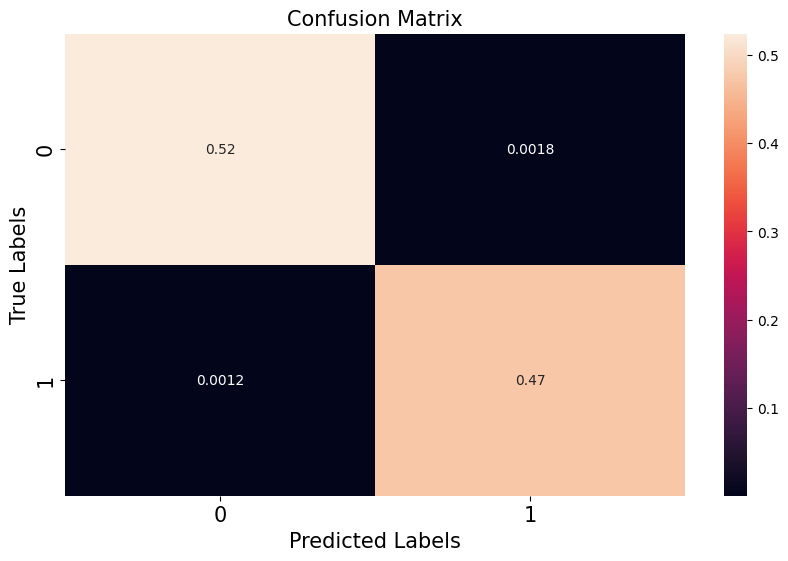

In [69]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

In [70]:
end = time.time()
print(end - start)

2050.57426738739


In [88]:
!pip install translate

In [89]:
!pip install langdetect

In [92]:
from translate import Translator
from langdetect import detect


def text_and_translate(user_title, user_text):

    news_text = user_title + " " + user_text

    translator = Translator(from_lang="ko", to_lang="en")

    if detect(news_text) != 'en':
         news_text = translator.translate(news_text)
    # print(news_text)
    return news_text



def predict_fake_or_real(news_text):


    # 전처리 단계
    news_text = preprocessor(news_text)
    news_text = ' '.join(tokenizer_porter(news_text))

    # TF-IDF 변환
    news_vector = tfidf.transform([news_text])

    # 모델을 사용하여 예측
    prediction = clf.predict(news_vector)
    prediction_proba = clf.predict_proba(news_vector)

    if prediction[0] == 0:  # prediction은 배열 형태로 반환되므로 prediction[0]을 사용
        return "Fake News", prediction_proba[0][0] * 100  # 가짜 뉴스일 확률
    else:
        return "Real News", prediction_proba[0][1] * 100  # 진짜 뉴스일 확률


def explain_prediction(news_text, result):


    news_text = preprocessor(news_text)
    news_text = ' '.join(tokenizer_porter(news_text))
    news_vector = tfidf.transform([news_text])

    feature_names = tfidf.get_feature_names_out()
    coefficients = clf.coef_[0]
    words_importance = []

    for idx in news_vector.nonzero()[1]:
        word = feature_names[idx]
        importance = coefficients[idx] * news_vector[0, idx]
        words_importance.append((word, importance))

    words_importance.sort(key=lambda x: abs(x[1]), reverse=True)

    if result == "Fake News":
        return [word for word in words_importance if word[1] < 0][:10]
    else:
        return [word for word in words_importance if word[1] > 0][:10]


while True:

    user_title = input("Please enter a news article title or 0 to exit: ").strip()

    if user_title == '0':
        print("Exiting the program.")
        break

    user_text = input("Please enter the news article text: ").strip()
    news_text = text_and_translate(user_title, user_text)

    result, probability = predict_fake_or_real(news_text)
    explanation = explain_prediction(news_text, result)


    print("This news is:", result)
    print(f"Probability: {probability:.2f}%")
    print("Top 10 influencing words:")
    for word, importance in explanation:
        print(f"{word}: {'supports Fake' if importance < 0 else 'supports Real'} with weight {abs(importance)}")

Please enter a news article title or 0 to exit: 폭우 내리는데 콘크리트 타설… 안전할까
Please enter the news article text: 서울에서 '극한호우' 긴급재난문자까지 발송된 지난 11일, 서울과 수도권의 일부 공사현장에서 콘크리트 타설 공정이 진행된 것을 놓고 논란이 일고 있다.  콘크리트에 빗물이 섞이면서 강도가 약해질 수 있다는 가정 속에 온라인 커뮤니티를 중심으로 우려가 확산하고 있다. 하지만 현행 지침 상 문제는 없는 것으로 나타났다.  12일 관련업계에 따르면 지난 11일 서울과 경기, 인천 등 일부 아파트 건설현장에서 콘크리트 타설 작업이 진행됐다. 온라인 커뮤니티를 중심으로 관련 사진이 퍼지면서 논란이 확산되고 있다. 물과 시멘트 비율은 콘크리트 강도를 결정짓는 핵심 조건이다. 우천 시 콘크리트를 타설할 경우 빗물로 인해 물의 비율이 늘어나 콘크리트 강도가 약해질 우려가 높아진다.
This news is: Real News
Probability: 90.22%
Top 10 influencing words:
seoul: supports Real with weight 1.8988762096124603
concret: supports Real with weight 1.0497165283373053
on: supports Real with weight 0.9114549944997083
onlin: supports Real with weight 0.8220332551478484
some: supports Real with weight 0.6431536304382358
in: supports Real with weight 0.6051400408165831
mix: supports Real with weight 0.37405458911801936
guidelin: supports Real with weight 0.3507323960890234
around: supports Real with weight